# News Article Classifier
We are classifying news articles into major categories using 5 machine learning models-
MultinomialNB
DecisionTreeClassifier
SGDClassifier
LGBMClassifier
XGBClassifier

 ### Import necessary libraries

In [1]:
#regular expression matching operations
import re  
#Linear Algebra
import numpy as np
#Data preprocessing
import pandas as pd
import seaborn as sns

# function to split the data for cross-validation
from sklearn.model_selection import train_test_split
# function for transforming documents into counts
from sklearn.feature_extraction.text import CountVectorizer

# Importing models
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier

# function for encoding categories
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix

# To help compare the algorithms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

### Import the dataset 

In [2]:
df = pd.read_csv("dataset_1.csv")
df1 = pd.read_csv("dataset_2.csv")
df2 = pd.read_csv("dataset_3.csv")

frames = [df, df1, df2]

articles = pd.concat(frames)
articles.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,211210,Charlie White and Sharna Burgess – Foxtrot – Dancing with the Stars 18 DWTS ...,...,www.zeibiz.com,1399987761278,422420,Wadleigh named Access Health CT's interim CEO,http://www.hartfordbusiness.com/article/20140827/NEWS01/140829938,Hartford Business,m,drbHX2-GkgsIZjMovsFKIC2IOEHBM,www.hartfordbusiness.com,1409225953391
0,1.0,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.394470e+12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.394470e+12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.394470e+12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

### Normalize the text in headlines 
Remove punctuation marks, and transform all to lowercase

In [3]:
def normalize_text(s):    
    #transform all letters to lowercase
    s=str(s)
    s=s.lower()
    # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W\s',' ',s)
    # remove double spaces
    s = re.sub('\s+',' ',s)
    return s

articles["TITLE_TEXT"] = [normalize_text(s) for s in articles["TITLE"]]    

Remove the null values present, replace them with 0.

In [4]:
articles.fillna(value = 0,inplace = True)

Ensure that the data type of required categories is workable

In [5]:
articles["CATEGORY"] = [str(s) for s in articles["CATEGORY"]]

In [6]:
articles.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,211210,Charlie White and Sharna Burgess – Foxtrot – Dancing with the Stars 18 DWTS ...,...,1399987761278,422420,Wadleigh named Access Health CT's interim CEO,http://www.hartfordbusiness.com/article/20140827/NEWS01/140829938,Hartford Business,m,drbHX2-GkgsIZjMovsFKIC2IOEHBM,www.hartfordbusiness.com,1409225953391,TITLE_TEXT
0,1.0,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.394470e+12,0.0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,fed official says weak data caused by weather ...
1,2.0,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.394470e+12,0.0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,fed's charles plosser sees high bar for change...
2,3.0,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12,0.0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,us open stocks fall after fed official hints a...
3,4.0,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12,0.0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,fed risks falling behind the curve' charles pl...
4,5.0,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.394470e+12,0.0,0,...,0.0,0.0,0,0,0,0,0,0,0.0,fed's plosser nasty weather has curbed job growth


## Pull the data into vectors

In [7]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(articles["TITLE_TEXT"])

In [8]:
encoder = LabelEncoder()
y = encoder.fit_transform(articles["CATEGORY"])

## Train-Test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_train.shape)

(337935, 40102)
(337935,)
(84484, 40102)
(337935,)


# MODEL CREATION -

## Naive Bayes 

In [11]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

MultinomialNB()

In [12]:
nbscore = nb.score(x_test, y_test)*100
nbpredict =nb.predict(x_test)

## Decision-Tree Classifier

In [13]:
DT=DecisionTreeClassifier()
DT.fit(x_train,y_train)


DecisionTreeClassifier()

In [14]:
dtpredict = DT.predict(x_test)
dtscore =DT.score(x_test,y_test)*100

##  Stochastic Gradient Descent Classifier

In [15]:
SGD=SGDClassifier()
SGD.fit(x_train,y_train)

SGDClassifier()

In [16]:
sdgpredict = SGD.predict(x_test)
sgdscore=SGD.score(x_test, y_test)*100

## XGBClassifier

In [17]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:09:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
xgbpredict = xgb.predict(x_test)
xgbscore=xgb.score(x_test, y_test)*100

## Light Gradient Boosting Classifier

In [19]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [20]:
lgbm=LGBMClassifier()
lgbm.fit(x_train,y_train)

LGBMClassifier()

In [21]:
lgbmpredict = lgbm.predict(x_test)
lgbmscore=lgbm.score(x_test, y_test)*100

# Comparison between models -

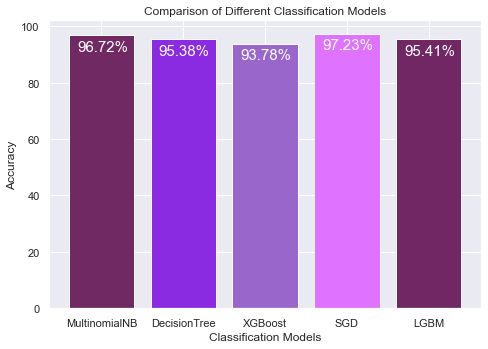

In [22]:
sns.set()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['MultinomialNB', 'DecisionTree','XGBoost', 'SGD','LGBM']
Accuracy=[nbscore,dtscore,xgbscore,sgdscore,lgbmscore]
ax.bar(Models,Accuracy,color=['#702963','#8a2be2','#9966cc','#df73ff','#702763']);
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()-5.5, str(round(i.get_height(),2))+'%', fontsize=15, color='white')
plt.title('Comparison of Different Classification Models');
plt.ylabel('Accuracy');
plt.xlabel('Classification Models');
plt.show();

In [23]:
print("-----------------------*-----------------------*-----------------------")
predictions = [nbpredict,dtpredict,xgbpredict,sdgpredict,lgbmpredict]
c=0
for i in  predictions:
    print(Models[c])
    print(classification_report(y_test, i))
    c=c+1
    print("-----------------------*-----------------------*-----------------------")

-----------------------*-----------------------*-----------------------
MultinomialNB
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     42174
         1.0       0.92      0.91      0.91     11599
         2.0       0.97      0.97      0.97     15575
         3.0       0.92      0.93      0.93      4278
         4.0       0.91      0.92      0.91     10858

    accuracy                           0.97     84484
   macro avg       0.94      0.94      0.94     84484
weighted avg       0.97      0.97      0.97     84484

-----------------------*-----------------------*-----------------------
DecisionTree
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     42174
         1.0       0.89      0.89      0.89     11599
         2.0       0.93      0.95      0.94     15575
         3.0       0.89      0.85      0.87      4278
         4.0       0.91      0.89      0.90     10858

    accuracy  